In [17]:
%matplotlib inline
#### Create Loan Data for Classification in Python ####
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from python.analysis import Plots

data = pd.read_csv("work/2023/Prod4a_1GeV_BeamSim_analysis/old_merge/merge-quantities.csv", nrows = 40000)
data = data[["alpha", "delta_x", "delta_xt", "delta_xl", "delta_phi", "d", "t", "p", "signal"]]
data.head()

# do a preselection on delta_x
data = data[data["t"] < 200] #* picked this value based on plots in geometric-quantities.ipynb


In [18]:
features = ["alpha", "delta_x", "delta_xt", "delta_xl", "delta_phi", "d", "t", "p"]
target = "signal"

X = data[features]
y = data[target]


In [19]:
#Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
def Fit(X_train, y_train, X_test, n_estimators: int):
    clf = XGBClassifier(max_depth = 3, learning_rate = 0.3, n_estimators = n_estimators, objective = 'binary:logistic', booster = 'gbtree')
    
    # Printing all the parameters of XGBoost
    # print(clf)
    
    # Creating the model on Training Data
    XGB = clf.fit(X_train, y_train)
    prediction = XGB.predict(X_test)
    return XGB, prediction


def Report(answer, prediction):
    # Measuring accuracy on Testing Data
    # print("confusion matrix")
    matrix = metrics.confusion_matrix(answer, prediction)
    # TODO decide what information in the report is useful to me
    # print("report")
    # print(metrics.classification_report(answer, prediction))
    # print(matrix)
    return {
        "FPR" : matrix[0][1] / (matrix[0][1] + matrix[0][0]),
        "FNR" : matrix[1][0] / (matrix[1][0] + matrix[1][1])
    }

def PlotFeatureImportance(XGB):
    #Plotting the feature importance for Top 10 most important columns
    feature_importances = pd.Series(XGB.feature_importances_, index = features)
    feature_importances.nlargest(10).plot(kind = 'barh')


In [31]:
# learing curves and validation
evalset = [(X_train, y_train), (X_test, y_test)]
clf = XGBClassifier(max_depth = 3, learning_rate = 0.1, n_estimators = 500, objective = 'binary:logistic', booster = 'gbtree')
XGB = clf.fit(X_train, y_train, eval_metric = 'logloss', eval_set = evalset)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.60375	validation_1-logloss:0.60475
[1]	validation_0-logloss:0.53053	validation_1-logloss:0.53240
[2]	validation_0-logloss:0.46951	validation_1-logloss:0.47231
[3]	validation_0-logloss:0.41801	validation_1-logloss:0.42185
[4]	validation_0-logloss:0.37384	validation_1-logloss:0.37835
[5]	validation_0-logloss:0.33607	validation_1-logloss:0.34130
[6]	validation_0-logloss:0.30327	validation_1-logloss:0.30906
[7]	validation_0-logloss:0.27481	validation_1-logloss:0.28117
[8]	validation_0-logloss:0.24982	validation_1-logloss:0.25671
[9]	validation_0-logloss:0.22790	validation_1-logloss:0.23535
[10]	validation_0-logloss:0.20874	validation_1-logloss:0.21686
[11]	validation_0-logloss:0.19175	validation_1-logloss:0.20034
[12]	validation_0-logloss:0.17680	validation_1-logloss:0.18579
[13]	validation_0-logloss:0.16340	validation_1-logloss:0.17285
[14]	validation_0-logloss:0.15166	validation_1-logloss:0.16166
[15]	validation_0-logloss:0.14121	validation_1-logloss:0.15171
[1

[[1831    4]
 [  31   11]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1835
        True       0.73      0.26      0.39        42

    accuracy                           0.98      1877
   macro avg       0.86      0.63      0.69      1877
weighted avg       0.98      0.98      0.98      1877



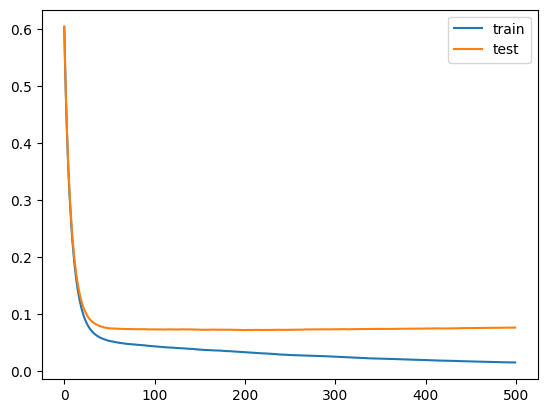

In [32]:
prediction = XGB.predict(X_test)
print(metrics.confusion_matrix(y_test, prediction))
print(metrics.classification_report(y_test, prediction))

results = XGB.evals_result()

# plot learning curves
Plots.plt.plot(results['validation_0']['logloss'], label='train')
Plots.plt.plot(results['validation_1']['logloss'], label='test' )
# show the legend
Plots.plt.legend()
# show the plot
Plots.plt.show()

In [21]:
n_estimators = np.arange(1, 1011, 10)

rates = {"FPR" : [], "FNR" : []}
for n in n_estimators:
    print(n, end = '\r')
    XGB, prediction = Fit(X_train, y_train, X_test, n)
    r = Report(y_test, prediction)

    for k, v in r.items():
        rates[k].append(v)



[[1827    8]
 [  33    9]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1835
        True       0.53      0.21      0.31        42

    accuracy                           0.98      1877
   macro avg       0.76      0.60      0.65      1877
weighted avg       0.97      0.98      0.97      1877

FPR


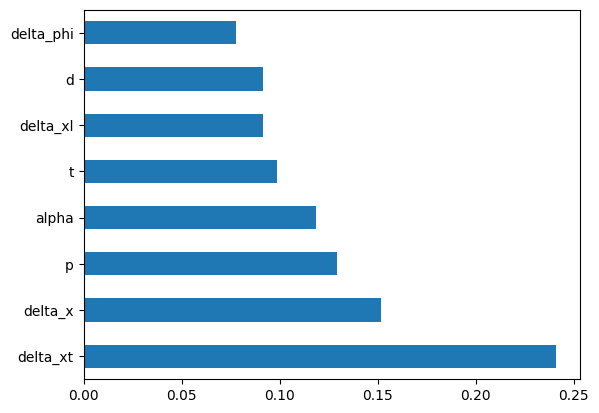

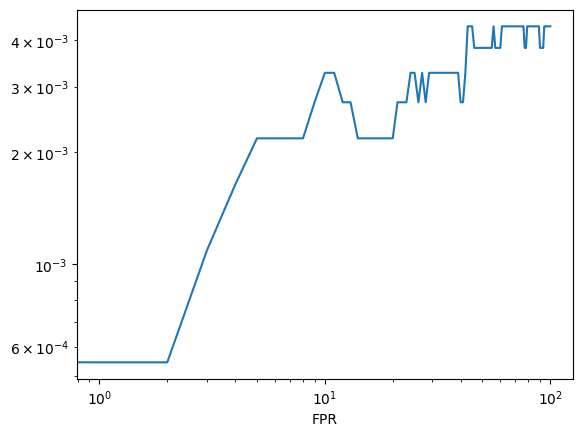

FNR


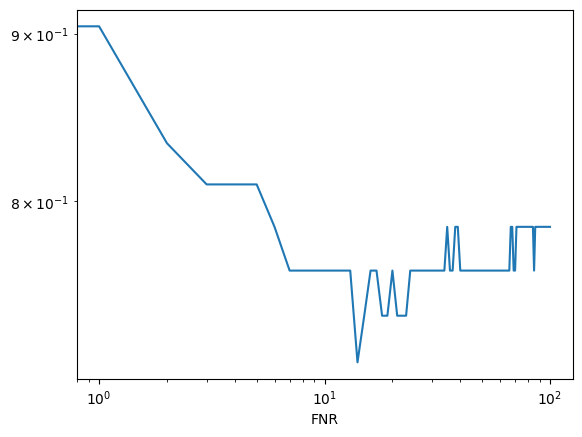

In [23]:
print(metrics.confusion_matrix(y_test, prediction))
print(metrics.classification_report(y_test, prediction))
PlotFeatureImportance(XGB)
for k in rates:
    print(k)
    Plots.plt.figure()
    Plots.plt.plot(rates[k])
    Plots.plt.xlabel(k)
    Plots.plt.yscale("log")
    Plots.plt.xscale("log")
    Plots.plt.show()

False precision = $\frac{tn}{tn + fn}$ - How often is the background PFO correctly found?

True precision = $\frac{tp}{tp + fp}$ - How often is the signal PFOs correctly found?

False recall = $\frac{tn}{tn + fp}$ - how often can it predict a PFO is background

True recall = $\frac{tp}{tp + fn}$ - how often can it predict a PFO is signal

False Positive rate = $\frac{fp}{fp + tn}$ - how often does it predict a background PFO as signal

False Negative rate = $\frac{fp}{fp + tn}$ - how often does it predict a signal PFO as background

